# **Breast Cancer Histopathology Images Modeling Through CNN**

In [1]:
import kagglehub
paultimothymooney_breast_histopathology_images_path = kagglehub.dataset_download('paultimothymooney/breast-histopathology-images')

print('Data source import complete.')

Data source import complete.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import random
import os
import cv2
#tesor fow & keras
import tensorflow as tf

from tensorflow.keras.optimizers import Adamax
from tensorflow import keras
from keras.regularizers import l2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense,BatchNormalization,Dropout,Input
from keras.models import Sequential, Model
from keras.layers import Conv2D,GlobalMaxPooling2D
from tensorflow.keras.applications import  Xception,VGG16,InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
#cnn
from tensorflow.keras import datasets, layers, models

from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.layers import Layer

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [3]:
import os
import cv2
import random
from sklearn.utils import shuffle

labels = ['0', '1']

# Load images with sampling from directory
def load_images_from_directory(main_directory, sample_ratio=0.05):
    total_labels = []
    images = []
    pathes = []
    total_normal = 0
    total_infected = 0

    folders = os.listdir(main_directory)
    for i, folder in enumerate(folders):
        # Skip the specified directory
        if folder == 'IDC_regular_ps50_idx5':
            continue

        for lab in labels:
            full_path = os.path.join(main_directory, folder, lab)

            # Check if the path exists to avoid errors
            if not os.path.exists(full_path):
                continue

            # Get all images from the current path
            image_files = os.listdir(full_path)
            # Sample 10% of images
            sampled_files = random.sample(image_files, int(len(image_files) * sample_ratio))

            for image in sampled_files:
                img = cv2.imread(os.path.join(full_path, image))
                img = cv2.resize(img, (50, 50))
                images.append(img)
                pathes.append(os.path.join(full_path, image))

                if lab == '0':
                    label = 0
                    total_normal += 1
                elif lab == '1':
                    label = 1
                    total_infected += 1
                total_labels.append(label)

    print('Total normal images:', total_normal)
    print('Total infected images:', total_infected)
    return shuffle(images, total_labels, pathes, random_state=756349782)

# Get label name
def get_Label(number):
    labels = {0: 'Uninfected', 1: 'Infected'}
    return labels[number]

image_path = '/kaggle/input/breast-histopathology-images/'
images, all_labels, pathes = load_images_from_directory(image_path)


Total normal images: 9792
Total infected images: 3817


In [4]:
df =pd.DataFrame({
    'image_path':pathes,
    'label':all_labels,

})
df

,image_path,label
0,/kaggle/input/breast-histopathology-images/897...,0
1,/kaggle/input/breast-histopathology-images/891...,0
2,/kaggle/input/breast-histopathology-images/103...,0
3,/kaggle/input/breast-histopathology-images/907...,0
4,/kaggle/input/breast-histopathology-images/912...,0
...,...,...
13604,/kaggle/input/breast-histopathology-images/129...,0
13605,/kaggle/input/breast-histopathology-images/917...,0
13606,/kaggle/input/breast-histopathology-images/898...,0
13607,/kaggle/input/breast-histopathology-images/103...,0


In [5]:
df['label'].value_counts()

,count
label,
0,9792
1,3817


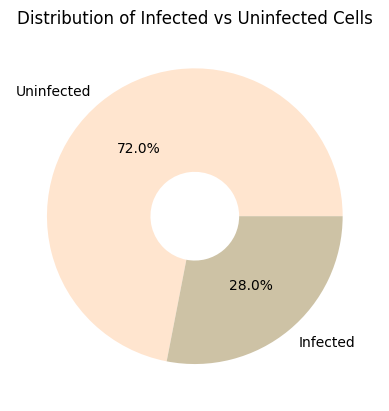

In [6]:
df.label.value_counts().plot(
    kind="pie",
    labels=["Uninfected", "Infected"],
    autopct='%1.1f%%',
    colors=["#FFE5CF", "#CDC2A5"],
    explode=(0, 0),
    wedgeprops=dict(width=0.7)
)

plt.title("Distribution of Infected vs Uninfected Cells")
plt.ylabel("")
plt.show()

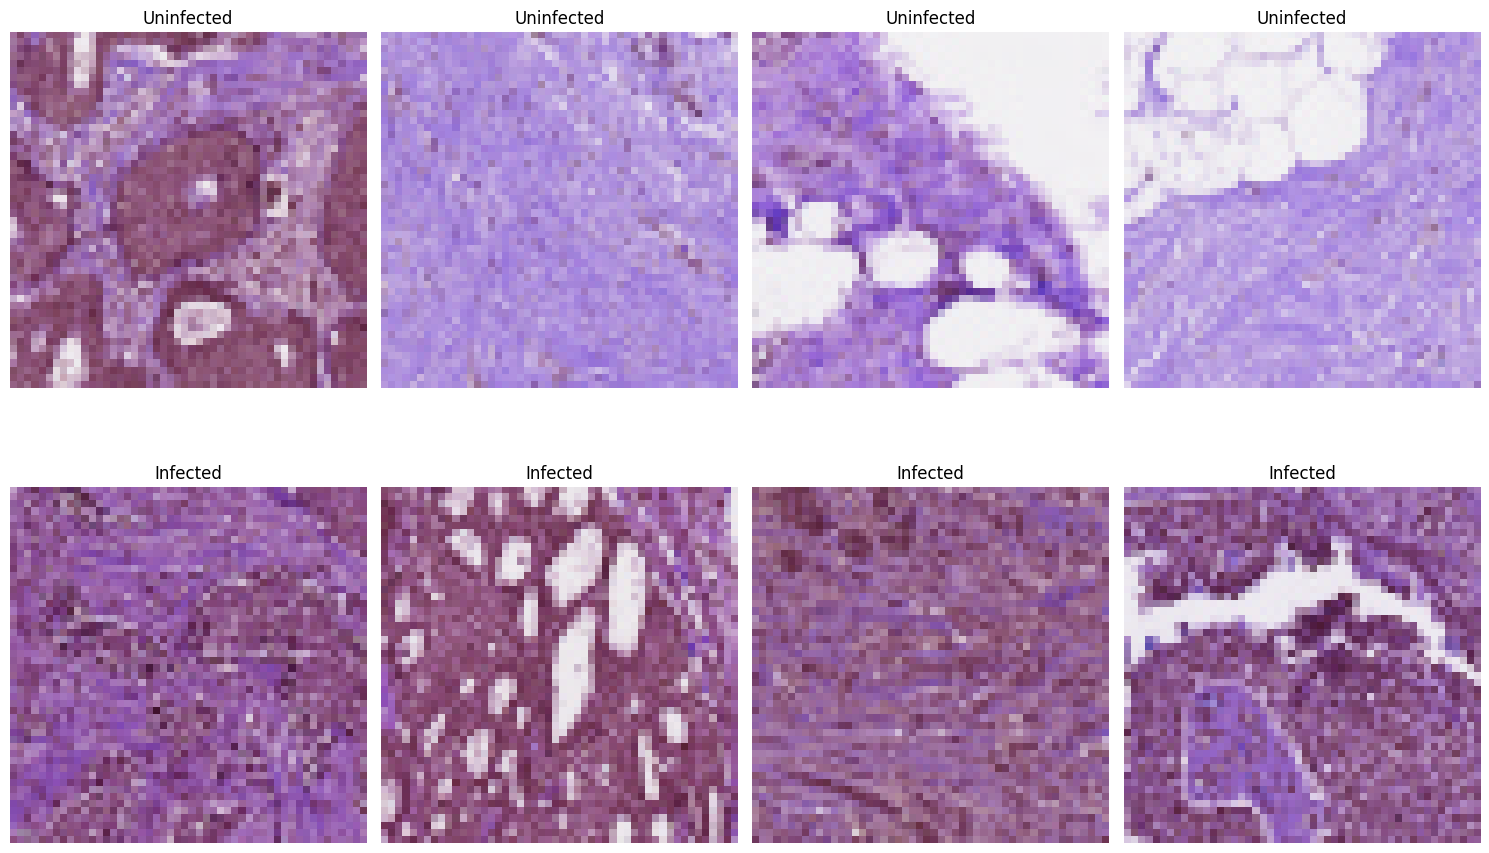

In [7]:
def visualize_images(images, labels):
    plt.figure(figsize=(15, 10))
    infected_count = 0
    uninfected_count = 0
    max_count = 4  # Plot 4 infected and 4 uninfected images
    total_count = max_count * 2
    plot_index = 1

    for i in range(len(images)):
        if labels[i] == 1 and infected_count < max_count:
            plt.subplot(2, 4, plot_index)
            plt.imshow(images[i])
            plt.title("Infected")
            plt.axis('off')
            infected_count += 1
            plot_index += 1
        elif labels[i] == 0 and uninfected_count < max_count:
            plt.subplot(2, 4, plot_index)
            plt.imshow(images[i])
            plt.title("Uninfected")
            plt.axis('off')
            uninfected_count += 1
            plot_index += 1

        # Stop when we have 4 infected and 4 uninfected
        if infected_count == max_count and uninfected_count == max_count:
            break

    plt.tight_layout()
    plt.show()

visualize_images(images, all_labels)


In [8]:
import os

# Base directory for the sampled dataset
base_dir = '/kaggle/working/breast-histopathology-sample'

# Directories for training and validation sets
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training normal and infected pictures
train_normal_dir = os.path.join(train_dir, 'normal')
train_infected_dir = os.path.join(train_dir, 'infected')

# Directory with our validation normal and infected pictures
validation_normal_dir = os.path.join(validation_dir, 'normal')
validation_infected_dir = os.path.join(validation_dir, 'infected')

# Print to verify the structure
print("Training Normal Directory: ", train_normal_dir)
print("Training Infected Directory: ", train_infected_dir)
print("Validation Normal Directory: ", validation_normal_dir)
print("Validation Infected Directory: ", validation_infected_dir)


Training Normal Directory:  /kaggle/working/breast-histopathology-sample/train/normal
Training Infected Directory:  /kaggle/working/breast-histopathology-sample/train/infected
Validation Normal Directory:  /kaggle/working/breast-histopathology-sample/validation/normal
Validation Infected Directory:  /kaggle/working/breast-histopathology-sample/validation/infected


In [9]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val, p_train, p_val = train_test_split(
    images, all_labels, pathes, train_size=0.8, random_state=42, stratify=all_labels
)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")


Training set size: 10887
Validation set size: 2722


In [10]:
import cv2
import os

def save_image(img, path, directory):
    filename = os.path.basename(path)
    save_path = os.path.join(directory, filename)
    cv2.imwrite(save_path, img)

# Save training images
for img, label, path in zip(X_train, y_train, p_train):
    if label == 0:
        save_image(img, path, train_normal_dir)
    else:
        save_image(img, path, train_infected_dir)

# Save validation images
for img, label, path in zip(X_val, y_val, p_val):
    if label == 0:
        save_image(img, path, validation_normal_dir)
    else:
        save_image(img, path, validation_infected_dir)

print("Images successfully saved to training and validation directories.")


Images successfully saved to training and validation directories.


In [13]:
import os
import cv2

def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Ensure that the directories exist
create_directory(train_normal_dir)
create_directory(train_infected_dir)
create_directory(validation_normal_dir)
create_directory(validation_infected_dir)

def save_image(img, path, directory):
    filename = os.path.basename(path)
    save_path = os.path.join(directory, filename)
    cv2.imwrite(save_path, img)

# Save training images
for img, label, path in zip(X_train, y_train, p_train):
    if label == 0:
        save_image(img, path, train_normal_dir)
    else:
        save_image(img, path, train_infected_dir)

# Save validation images
for img, label, path in zip(X_val, y_val, p_val):
    if label == 0:
        save_image(img, path, validation_normal_dir)
    else:
        save_image(img, path, validation_infected_dir)

print("Images successfully saved to training and validation directories.")

# Print the number of images in each directory
print('Total training normal images:', len(os.listdir(train_normal_dir)))
print('Total training infected images:', len(os.listdir(train_infected_dir)))
print('Total validation normal images:', len(os.listdir(validation_normal_dir)))
print('Total validation infected images:', len(os.listdir(validation_infected_dir)))


Images successfully saved to training and validation directories.
Total training normal images: 7833
Total training infected images: 3054
Total validation normal images: 1959
Total validation infected images: 763


In [14]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

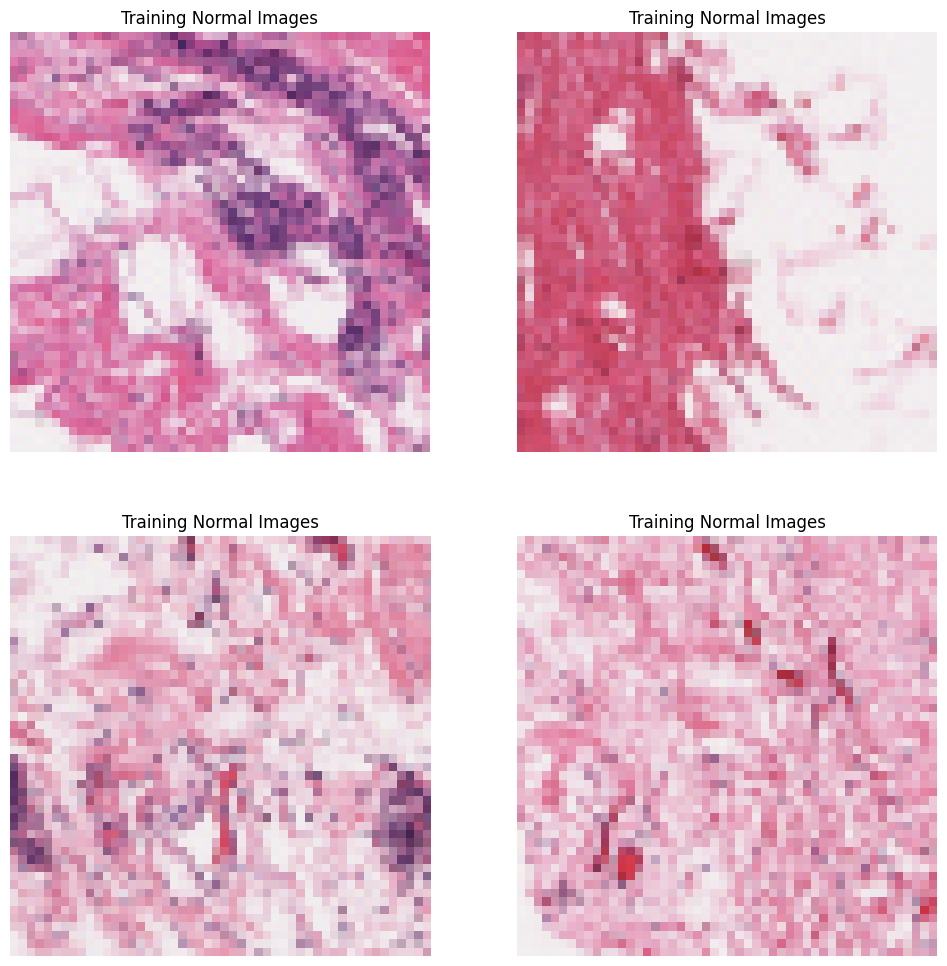

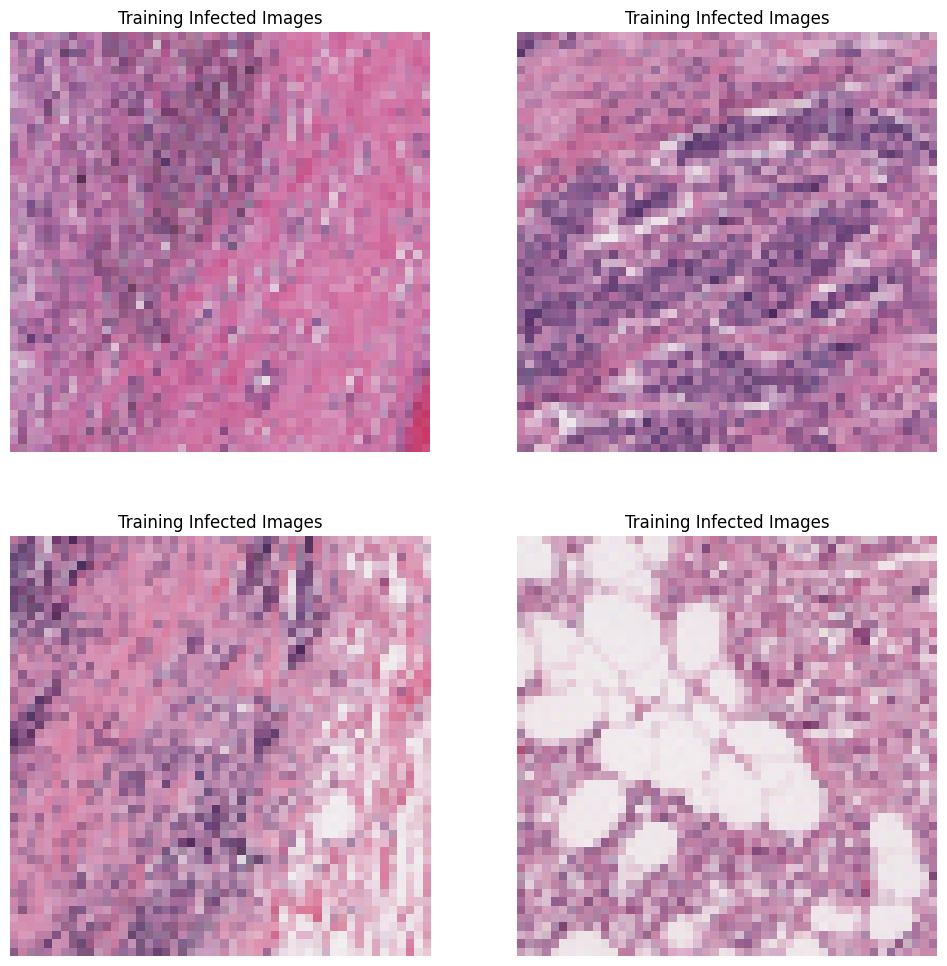

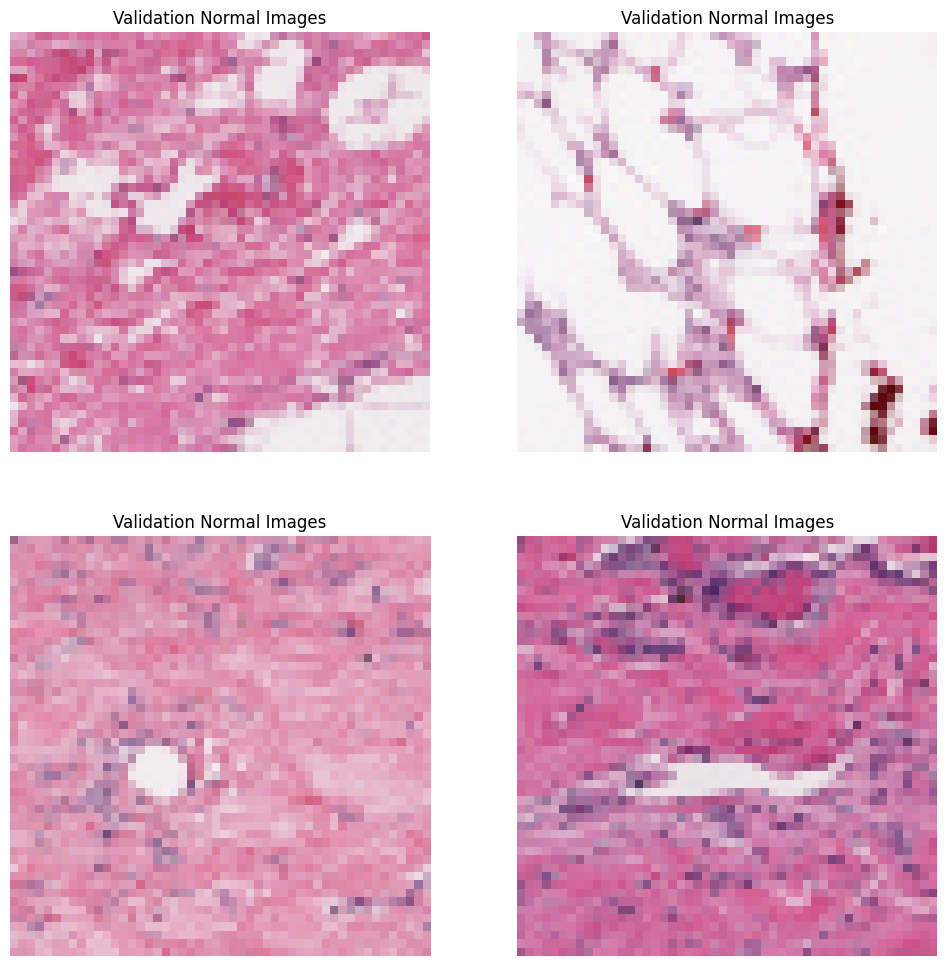

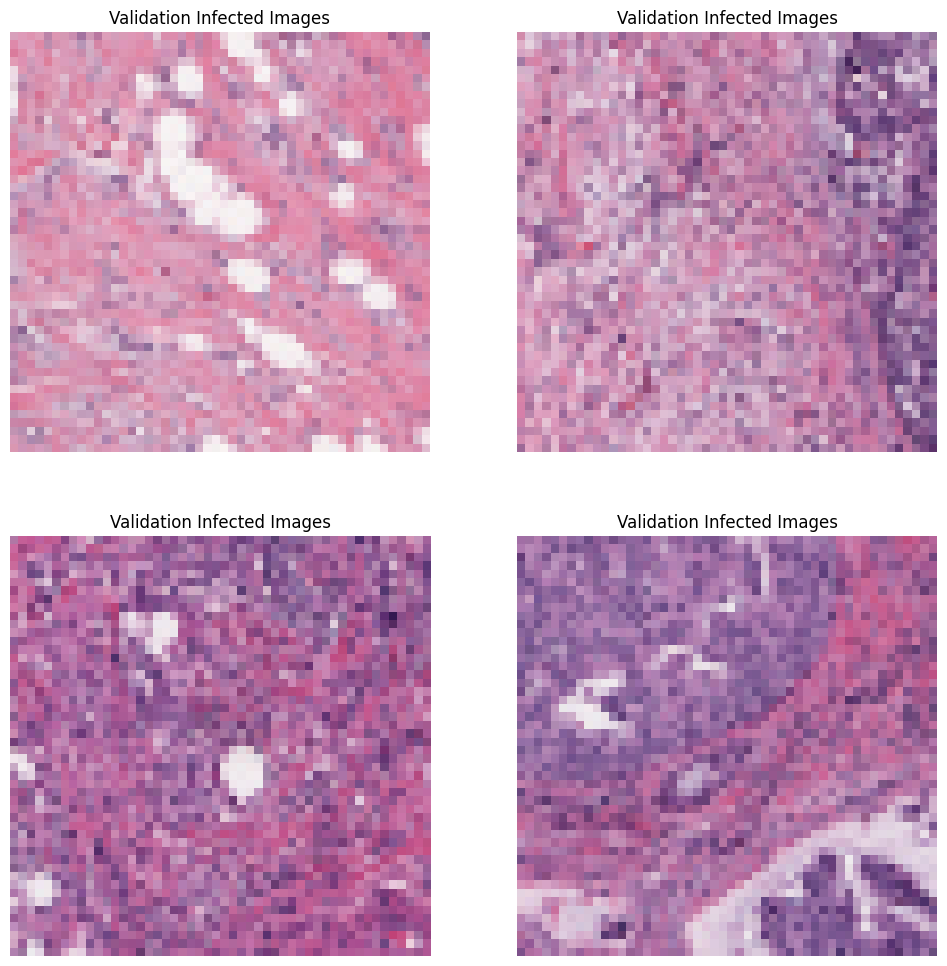

In [15]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Set up the directory paths
train_normal_dir = '/kaggle/working/breast-histopathology-sample/train/normal'
train_infected_dir = '/kaggle/working/breast-histopathology-sample/train/infected'
validation_normal_dir = '/kaggle/working/breast-histopathology-sample/validation/normal'
validation_infected_dir = '/kaggle/working/breast-histopathology-sample/validation/infected'

# Number of images to display
num_images = 4

# Helper function to show images
def show_images(image_paths, title):
    plt.figure(figsize=(12, 12))
    for i, img_path in enumerate(image_paths):
        plt.subplot(2, 2, i + 1)  # 2x2 grid
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.show()

# Select random images from each category
train_normal_images = random.sample(os.listdir(train_normal_dir), num_images)
train_infected_images = random.sample(os.listdir(train_infected_dir), num_images)
validation_normal_images = random.sample(os.listdir(validation_normal_dir), num_images)
validation_infected_images = random.sample(os.listdir(validation_infected_dir), num_images)

# Create file paths
train_normal_paths = [os.path.join(train_normal_dir, img) for img in train_normal_images]
train_infected_paths = [os.path.join(train_infected_dir, img) for img in train_infected_images]
validation_normal_paths = [os.path.join(validation_normal_dir, img) for img in validation_normal_images]
validation_infected_paths = [os.path.join(validation_infected_dir, img) for img in validation_infected_images]

# Show images
show_images(train_normal_paths, 'Training Normal Images')
show_images(train_infected_paths, 'Training Infected Images')
show_images(validation_normal_paths, 'Validation Normal Images')
show_images(validation_infected_paths, 'Validation Infected Images')



## Building the Model

In [16]:
from tensorflow.keras import layers
from tensorflow.keras import Model

## One-Layer CNN (No Dropout):

In [22]:


# Our input feature map: 50x50 for the image pixels, and 3 for the color channels (RGB)
img_input = layers.Input(shape=(50, 50, 3))

# Single convolution block
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(img_input)
x = layers.MaxPooling2D((2, 2))(x)

# Flatten the feature map to a 1-dimensional tensor
x = layers.Flatten()(x)

# Fully connected layer with 256 hidden units and ReLU activation
x = layers.Dense(256, activation='relu')(x)

# Output layer with a single neuron and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Create model
model1 = models.Model(inputs=img_input, outputs=output)

# Compile the model
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model1.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 50, 50, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 20000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     5,120,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,121,409 (19.54 MB)

 Trainable params: 5,121,409 (19.54 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
from tensorflow.keras.optimizers import RMSprop

model1.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['acc'])

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/kaggle/working/breast-histopathology-sample/train',  # Training directory
        target_size=(50, 50),  # Resize to match input size
        batch_size=32,  # Updated batch size for better performance
        class_mode='binary')  # Binary classification (normal vs infected)

# Flow validation images in batches of 32 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        '/kaggle/working/breast-histopathology-sample/validation',  # Validation directory
        target_size=(50, 50),  # Resize to match input size
        batch_size=32,  # Same batch size as training
        class_mode='binary')  # Binary classification

Found 10887 images belonging to 2 classes.
Found 2722 images belonging to 2 classes.


In [25]:
history = model1.fit(
    train_generator,
    steps_per_epoch=len(train_generator),  # Automatically calculated
    epochs=15,  # Number of training epochs
    validation_data=validation_generator,
    validation_steps=len(validation_generator),  # Automatically calculated
    verbose=2,  # Detailed output
)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


341/341 - 45s - 133ms/step - acc: 0.7550 - loss: 0.6424 - val_acc: 0.8159 - val_loss: 0.4087
Epoch 2/15
341/341 - 90s - 265ms/step - acc: 0.7985 - loss: 0.4432 - val_acc: 0.8189 - val_loss: 0.4152
Epoch 3/15
341/341 - 72s - 211ms/step - acc: 0.8115 - loss: 0.4159 - val_acc: 0.8193 - val_loss: 0.4103
Epoch 4/15
341/341 - 80s - 234ms/step - acc: 0.8215 - loss: 0.4012 - val_acc: 0.8145 - val_loss: 0.3981
Epoch 5/15
341/341 - 40s - 117ms/step - acc: 0.8298 - loss: 0.3874 - val_acc: 0.8079 - val_loss: 0.4070
Epoch 6/15
341/341 - 42s - 123ms/step - acc: 0.8370 - loss: 0.3706 - val_acc: 0.8303 - val_loss: 0.3771
Epoch 7/15
341/341 - 40s - 116ms/step - acc: 0.8492 - loss: 0.3455 - val_acc: 0.8325 - val_loss: 0.3816
Epoch 8/15
341/341 - 39s - 115ms/step - acc: 0.8546 - loss: 0.3315 - val_acc: 0.8211 - val_loss: 0.4096
Epoch 9/15
341/341 - 40s - 117ms/step - acc: 0.8675 - loss: 0.3049 - val_acc: 0.8321 - val_loss: 0.4090
Epoch 10/15
341/341 - 42s - 123ms/step - acc: 0.8812 - loss: 0.2793 - val_a

Text(0.5, 1.0, 'Training and validation loss')

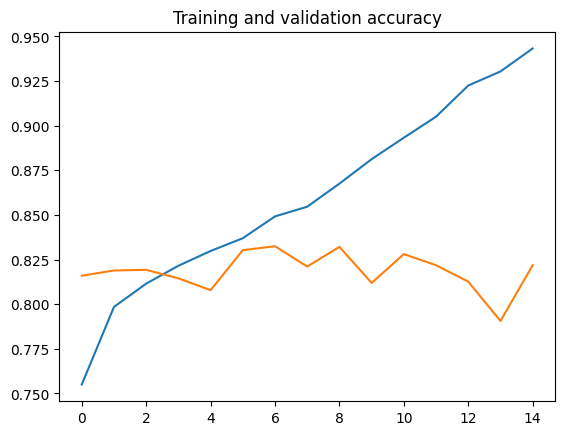

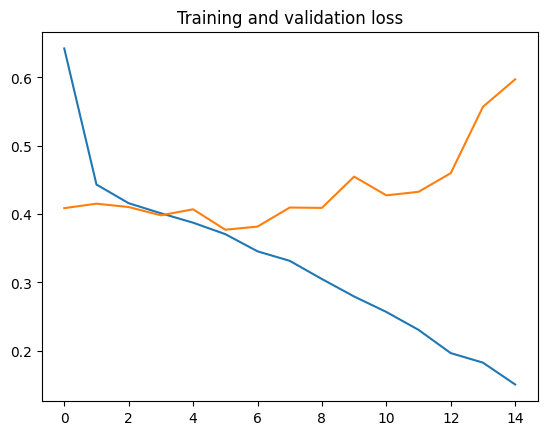

In [26]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

**Training and Validation Accuracy:**
- The blue line represents the training accuracy, which shows a steady increase throughout the 15 epochs, eventually reaching approximately 0.95.
- The orange line represents the validation accuracy, which initially increases but then plateaus around 0.82, with some fluctuations after the first few epochs.
- This divergence between the training and validation accuracy indicates that the model is learning well on the training data but is not generalizing effectively to the validation data.


**Training and Validation Loss:**
- The blue line shows a rapid decrease in training loss, reaching around 0.2, indicating that the model is fitting the training data effectively.
- The orange line, representing validation loss, initially decreases but then starts to increase after around 7 epochs, suggesting overfitting. The loss continues to rise, indicating that the model is becoming too specific to the training data and losing its ability to generalize.



## Two-Layer CNN (With Dropout):


In [17]:
from tensorflow.keras import layers, models

# Our input feature map: 50x50 for the image pixels, and 3 for the color channels (RGB)
img_input = layers.Input(shape=(50, 50, 3))

# First convolution block
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(img_input)
x = layers.MaxPooling2D((2, 2))(x)

# Second convolution block
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Flatten the feature map to a 1-dimensional tensor
x = layers.Flatten()(x)

# Fully connected layer with 256 hidden units and ReLU activation
x = layers.Dense(256, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Output layer with a single neuron and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Create model
model0 = models.Model(inputs=img_input, outputs=output)

# Compile the model
model0.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model0.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 50, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 50, 50, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,379,201 (9.08 MB)

 Trainable params: 2,379,201 (9.08 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
from tensorflow.keras.optimizers import RMSprop

model0.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['acc'])

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/kaggle/working/breast-histopathology-sample/train',  # Training directory
        target_size=(50, 50),  # Resize to match input size
        batch_size=32,  # Updated batch size for better performance
        class_mode='binary')  # Binary classification (normal vs infected)

# Flow validation images in batches of 32 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        '/kaggle/working/breast-histopathology-sample/validation',  # Validation directory
        target_size=(50, 50),  # Resize to match input size
        batch_size=32,  # Same batch size as training
        class_mode='binary')  # Binary classification

Found 10887 images belonging to 2 classes.
Found 2722 images belonging to 2 classes.


In [20]:
history = model0.fit(
    train_generator,
    steps_per_epoch=len(train_generator),  # Automatically calculated
    epochs=15,  # Number of training epochs
    validation_data=validation_generator,
    validation_steps=len(validation_generator),  # Automatically calculated
    verbose=2,  # Detailed output
)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


341/341 - 55s - 162ms/step - acc: 0.7500 - loss: 0.5478 - val_acc: 0.8222 - val_loss: 0.4417
Epoch 2/15
341/341 - 85s - 250ms/step - acc: 0.8029 - loss: 0.4509 - val_acc: 0.8266 - val_loss: 0.4073
Epoch 3/15
341/341 - 77s - 226ms/step - acc: 0.8165 - loss: 0.4259 - val_acc: 0.7719 - val_loss: 0.4745
Epoch 4/15
341/341 - 53s - 155ms/step - acc: 0.8226 - loss: 0.4107 - val_acc: 0.7810 - val_loss: 0.5198
Epoch 5/15
341/341 - 53s - 155ms/step - acc: 0.8239 - loss: 0.4040 - val_acc: 0.8398 - val_loss: 0.3768
Epoch 6/15
341/341 - 54s - 157ms/step - acc: 0.8304 - loss: 0.3965 - val_acc: 0.8395 - val_loss: 0.3693
Epoch 7/15
341/341 - 80s - 233ms/step - acc: 0.8328 - loss: 0.3838 - val_acc: 0.8336 - val_loss: 0.3685
Epoch 8/15
341/341 - 53s - 156ms/step - acc: 0.8359 - loss: 0.3821 - val_acc: 0.8288 - val_loss: 0.3767
Epoch 9/15
341/341 - 55s - 160ms/step - acc: 0.8411 - loss: 0.3726 - val_acc: 0.8240 - val_loss: 0.3953
Epoch 10/15
341/341 - 80s - 235ms/step - acc: 0.8470 - loss: 0.3634 - val_a

Text(0.5, 1.0, 'Training and validation loss')

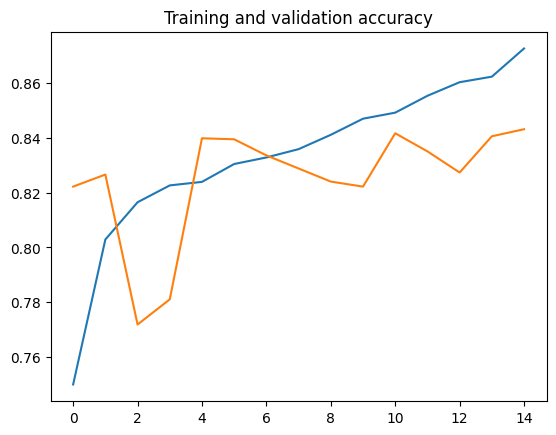

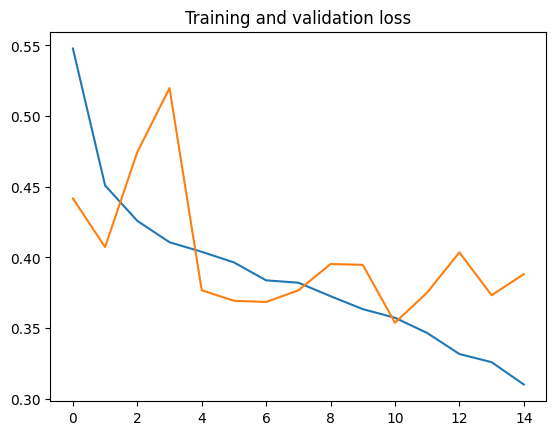

In [21]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

**Training and Validation Accuracy:**
- The blue line represents the training accuracy, which shows a consistent upward trend, reaching around 0.87 by the end of the training period.
- The orange line, representing validation accuracy, shows initial fluctuations but stabilizes around 0.84 after a few epochs, maintaining relatively stable performance with minor variations.
- Unlike the previous model, the gap between training and validation accuracy is significantly reduced, indicating improved generalization.


**Training and Validation Loss:**
- The blue line for training loss decreases steadily throughout the training process, indicating continuous improvement in fitting the training data.
- The orange line for validation loss initially shows some fluctuation but then generally decreases, indicating better model stability compared to the previous single-layer model.
- The decrease in validation loss along with stable accuracy suggests that the dropout layer successfully mitigated overfitting, allowing the model to generalize better to unseen data.




## Four-Layer CNN (With Dropout):


In [27]:
from tensorflow.keras import layers, models

# Our input feature map: 50x50 for the image pixels, and 3 for the color channels (RGB)
img_input = layers.Input(shape=(50, 50, 3))

# First convolution block
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(img_input)
x = layers.MaxPooling2D((2, 2))(x)

# Second convolution block
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Third convolution block
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Fourth convolution block
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Dropout
x = layers.Dropout(0.5)(x)

# Flatten the feature map to a 1-dimensional tensor
x = layers.Flatten()(x)

# Fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Output layer with a single neuron and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Create model
model2 = models.Model(inputs=img_input, outputs=output)

# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model2.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 50, 50, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,569,089 (5.99 MB)

 Trainable params: 1,569,089 (5.99 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/kaggle/working/breast-histopathology-sample/train',  # Training directory
        target_size=(50, 50),  # Resize to match input size
        batch_size=32,  # Updated batch size for better performance
        class_mode='binary')  # Binary classification (normal vs infected)

# Flow validation images in batches of 32 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        '/kaggle/working/breast-histopathology-sample/validation',  # Validation directory
        target_size=(50, 50),  # Resize to match input size
        batch_size=32,  # Same batch size as training
        class_mode='binary')  # Binary classification


Found 10887 images belonging to 2 classes.
Found 2722 images belonging to 2 classes.


In [29]:
history = model2.fit(
    train_generator,
    steps_per_epoch=len(train_generator),  # Automatically calculated
    epochs=15,  # Number of training epochs
    validation_data=validation_generator,
    validation_steps=len(validation_generator),  # Automatically calculated
    verbose=2,  # Detailed output
)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


341/341 - 93s - 273ms/step - accuracy: 0.7698 - loss: 0.4894 - val_accuracy: 0.8196 - val_loss: 0.4029
Epoch 2/15
341/341 - 88s - 257ms/step - accuracy: 0.8187 - loss: 0.4153 - val_accuracy: 0.8101 - val_loss: 0.4197
Epoch 3/15
341/341 - 98s - 287ms/step - accuracy: 0.8280 - loss: 0.4008 - val_accuracy: 0.8211 - val_loss: 0.4279
Epoch 4/15
341/341 - 131s - 385ms/step - accuracy: 0.8328 - loss: 0.3962 - val_accuracy: 0.8339 - val_loss: 0.3804
Epoch 5/15
341/341 - 87s - 254ms/step - accuracy: 0.8337 - loss: 0.3867 - val_accuracy: 0.8255 - val_loss: 0.4019
Epoch 6/15
341/341 - 143s - 420ms/step - accuracy: 0.8365 - loss: 0.3763 - val_accuracy: 0.8343 - val_loss: 0.3882
Epoch 7/15
341/341 - 143s - 419ms/step - accuracy: 0.8436 - loss: 0.3684 - val_accuracy: 0.8134 - val_loss: 0.4076
Epoch 8/15
341/341 - 143s - 418ms/step - accuracy: 0.8361 - loss: 0.3824 - val_accuracy: 0.8395 - val_loss: 0.3690
Epoch 9/15
341/341 - 92s - 270ms/step - accuracy: 0.8435 - loss: 0.3684 - val_accuracy: 0.8347 

Text(0.5, 1.0, 'Training and validation loss')

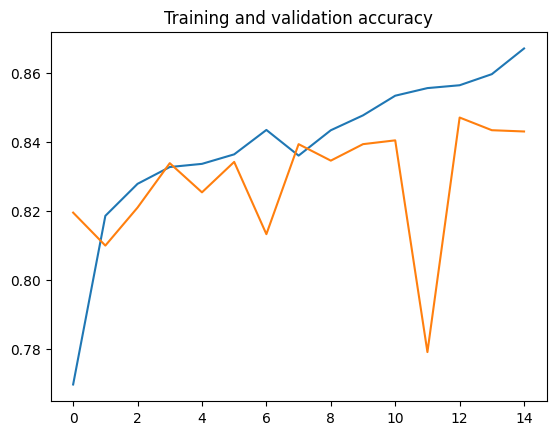

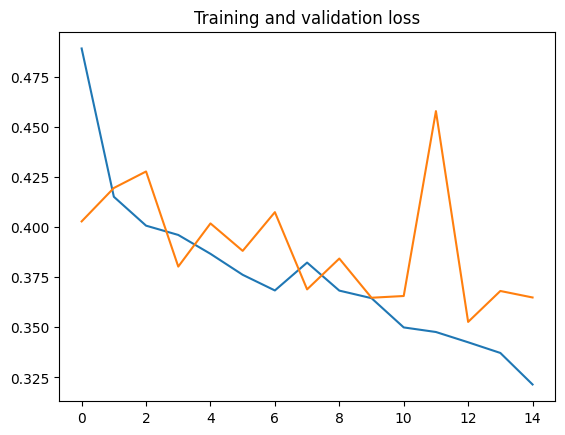

In [34]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

**Training and Validation Accuracy:**
- The blue line represents the training accuracy, which shows a consistent upward trend, reaching around 0.87 by the final epoch.
- The orange line represents the validation accuracy, which fluctuates more compared to previous models but stabilizes around 0.84 after 15 epochs.
- A significant dip in validation accuracy around epoch 11 indicates possible instability or a momentary overfitting issue, but the accuracy quickly recovers.
- Despite some variability, the training and validation accuracy curves are more aligned compared to the simpler models, suggesting improved generalization.


**Training and Validation Loss:**
- The blue line shows a gradual and consistent decrease in training loss, indicating that the model continues to improve its fit on the training data.
- The orange line for validation loss also shows a general downward trend, although there is a noticeable spike at around epoch 11, corresponding to the drop in validation accuracy.
- The model eventually recovers, and the loss decreases again, suggesting that the model learned to generalize better after overcoming the temporary instability.


# Batch Normalization and Early Stopping On 30 Epochs

In [35]:
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# Our input feature map: 50x50 for the image pixels, and 3 for the color channels (RGB)
img_input = layers.Input(shape=(50, 50, 3))

# First convolution block with Batch Normalization
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(img_input)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

# Second convolution block with Batch Normalization
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

# Third convolution block with Batch Normalization
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

# Fourth convolution block with Batch Normalization
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

# Dropout for regularization
x = layers.Dropout(0.5)(x)

# Flatten the feature map to a 1-dimensional tensor
x = layers.Flatten()(x)

# Fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Output layer with a single neuron and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Create model
model2 = models.Model(inputs=img_input, outputs=output)

# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model2.summary()

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model2.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,  # Increased epochs for more training
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stopping],  # Include Early Stopping
    verbose=2
)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 50, 50, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 50, 50, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 25, 25, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,571,009 (5.99 MB)

 Trainable params: 1,570,049 (5.99 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/30
341/341 - 116s - 339ms/step - accuracy: 0.8125 - loss: 0.5029 - val_accuracy: 0.4629 - val_loss: 0.9137
Epoch 2/30
341/341 - 139s - 408ms/step - accuracy: 0.8418 - loss: 0.3698 - val_accuracy: 0.8453 - val_loss: 0.3626
Epoch 3/30
341/341 - 141s - 413ms/step - accuracy: 0.8499 - loss: 0.3568 - val_accuracy: 0.8292 - val_loss: 0.4414
Epoch 4/30
341/341 - 143s - 420ms/step - accuracy: 0.8504 - loss: 0.3472 - val_accuracy: 0.7946 - val_loss: 0.4352
Epoch 5/30
341/341 - 108s - 316ms/step - accuracy: 0.8584 - loss: 0.3379 - val_accuracy: 0.8384 - val_loss: 0.4224
Epoch 6/30
341/341 - 106s - 310ms/step - accuracy: 0.8582 - loss: 0.3336 - val_accuracy: 0.7987 - val_loss: 0.4062
Epoch 7/30
341/341 - 142s - 417ms/step - accuracy: 0.8600 - loss: 0.3282 - val_accuracy: 0.8457 - val_loss: 0.3579
Epoch 8/30
341/341 - 146s - 427ms/step - accuracy: 0.8613 - loss: 0.3267 - val_accuracy: 0.7752 - val_loss: 0.7709
Epoch 9/30
341/341 - 136s - 400ms/step - accuracy: 0.8712 - loss: 0.3130 - val_a

Text(0.5, 1.0, 'Training and validation loss')

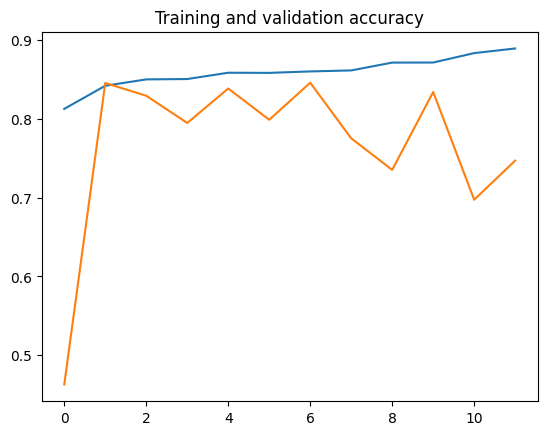

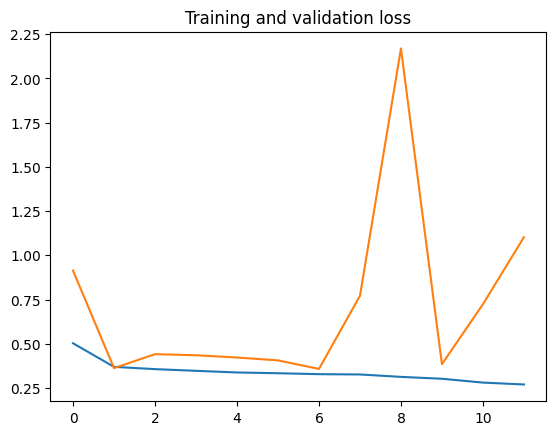

In [36]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

**Reason for Stopping:**
- The patience=5 parameter in EarlyStopping means that the model stops if the validation loss does not improve for 5 consecutive epochs.
- Around epoch 6, the validation accuracy peaked at 0.8, while the validation loss reached a minimum of 0.4 at epoch 6.
- At Epoch 7, the validation accuracy started to decrease and fluctuate significantly, and the validation loss spiked, indicating that the model had started to overfit the training data.

**Training and Validation Accuracy:**
- Training Accuracy:
  - Starts at 0.81 and gradually increases to 0.88 by epoch 12.
  - The accuracy consistently improves, showing that the model is effectively learning the training data.
- Validation Accuracy:
  - Initially increases to around 0.84 at epoch 1.
  - Shows a significant drop at epoch 10 to 0.69.
  - The accuracy fluctuates in the later epochs, indicating that the model struggles to maintain consistent validation performance.


**Training and Validation Loss:**
- Training Loss:
  - Decreases steadily from 0.50 to 0.27, reflecting consistent learning.
  - The continuous decline suggests that the model fits the training data increasingly well.
- Validation Loss:
  - Initially decreases, reaching around 0.3 by epoch 6.
  - A sudden spike occurs at epoch 8, where the loss jumps to 2.1690.
  - After the spike, the loss decreases again, but another smaller spike occurs at epoch 10 (1.1023).
  - These sudden increases in validation loss indicate that the model overfits during specific training points.
